## ECS171 HW2

In [2]:
import pandas as pd
import numpy as np
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [25]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from keras.callbacks import Callback
from keras import metrics
from keras import backend as K
from keras import optimizers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

### Loading the dataset

In [5]:
yeast = pd.read_csv('G:/ecs171/yeast.data', header = None, sep = '\s+', index_col = 0)
yeast.head()

,1,2,3,4,5,6,7,8,9
0,,,,,,,,,
ADT1_YEAST,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,MIT
ADT2_YEAST,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,MIT
ADT3_YEAST,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,MIT
AAR2_YEAST,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,NUC
AATM_YEAST,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,MIT


The are 1484 samples in the dataset 'yeast'. Each sample has 8 features and 1 class.

In [6]:
num = pd.DataFrame(yeast.loc[:,9].value_counts())
num.columns = ['Number']
num

,Number
CYT,463
NUC,429
MIT,244
ME3,163
ME2,51
ME1,44
EXC,35
VAC,30
POX,20
ERL,5


There are 10 different classes in the dataset, the number of each class is shown in the table above. 

### P1.  Outlier detection

In [7]:
lof = LocalOutlierFactor(contamination=0.01)
#lof = LocalOutlierFactor()
pred_lof = lof.fit_predict(yeast.loc[:,1:8])
sum(pred_lof == -1)

15

In [8]:
yeast.iloc[pred_lof == 1].loc[:,9].value_counts()

CYT    457
NUC    428
MIT    244
ME3    163
ME2     50
ME1     44
EXC     35
VAC     30
POX     13
ERL      5
Name: 9, dtype: int64

The number of each class after remove outliers detected by the LOF algorithm is shown in the table above.

In [9]:
isof = IsolationForest(contamination=0.01, behaviour='new')
pred_isof = isof.fit_predict(yeast.loc[:,1:8])
sum(pred_isof == -1)

15

In [10]:
yeast.iloc[pred_isof == 1].loc[:,9].value_counts()

CYT    460
NUC    427
MIT    244
ME3    162
ME2     50
ME1     41
EXC     35
VAC     30
POX     20
Name: 9, dtype: int64

The number of each class after remove outliers detected by the Isolation Forest algorithm is shown in the table above.

The LOF and Isolation Forest algorithms were used to detect outliers.

According to the LOF algorihm, there are 30 outliers in the dataset. According to the Isolation Forest algorithm, there are 30 outliers in the dataset too. However, the 30 outliers detected by the two algorithm are not the same. According to the tables above, the Isolation Forest algorithm identifies all the samples in ERL class as outliers.

The LOF algorithm assumes that outliers have a substatially lower density than their neighbors. The Isolation Forest algorithm assumes that random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies. 

(Novelty and Outlier Detection from https://scikit-learn.org/stable/modules/outlier_detection.html)

To keep all the 10 classes in the dataset, the LOF algorithm was used to remove the outliers. There are 1454 samples in the new dataset.

In [11]:
yeast_new = yeast.iloc[pred_lof == 1]

### P2. 4-layer ANN

First, I transformed the class of each sample to a vector. The ith element is set to 1, and all the other elements are set to 0 if the class of the sample is at the ith position. Then the dataset were split into a random set of 66% of the samples as the training set, and the rest 34% as the testing set. Normalization were then applied. 

In [12]:
X = yeast_new.loc[:,1:8].values
y = yeast_new.loc[:,9].values

In [13]:
ec = LabelEncoder()
y = ec.fit_transform(y)

In [14]:
dummy_y = to_categorical(y)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, dummy_y, test_size = 0.34, random_state = 123)

In [16]:
#unique, counts = np.unique(y_train.argmax(axis = 1), return_counts=True)
#dict(zip(unique, counts))

In [17]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

A 4 layer (2 hidden layers, 3 nodes per hidden layer) ANN was built. ANN model was constructed, and trained with the training set. The learning rate of SGD was set to 6, epoch was set to 200. 

In [125]:
model = Sequential()
model.add(Dense(3, input_dim = 8, activation = 'sigmoid'))
model.add(Dense(3, activation = 'sigmoid'))
model.add(Dense(10, activation = 'sigmoid'))
sgd = optimizers.SGD(lr = 6)
model.compile(loss = 'mean_squared_error', optimizer = 'sgd', metrics = ['accuracy'])

track={'weight_1':[], 'weight_2':[], 'weight_3':[], 'bias':[]}
error={'train':[], 'test':[]}

In [13]:
true_train = y_train.argmax(axis=1)
true_test = y_test.argmax(axis=1)

In [14]:
def calc_error(true, pred):
    m = confusion_matrix(true, pred)
    #return 1-(m.diagonal()[0] + m.diagonal()[1:].sum())/m.sum()
    return 1 - (m.diagonal()[0] + m[1:,1:].sum())/m.sum()

In [122]:
class Track(Callback):
    def on_epoch_end(self, epoch, logs={}):
        a,b,c = model.layers[2].get_weights()[0][:,0]
        track['weight_1'].append(a)
        track['weight_2'].append(b)
        track['weight_3'].append(c)
        track['bias'].append(model.layers[2].get_weights()[1][0])
        
        pred_train = model.predict(X_train).argmax(axis=1)
        pred_test = model.predict(X_test).argmax(axis=1)

        error['train'].append(calc_error(true_train, pred_train))
        error['test'].append(calc_error(true_test, pred_test))
        

In [126]:
history = model.fit(X_train, y_train, epochs = 200, callbacks=[Track()], verbose=0)

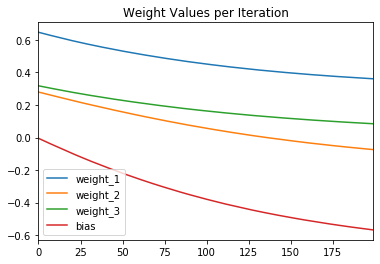

In [222]:
track = pd.DataFrame(track)
track.plot(title = 'Weight Values per Iteration')

The weights values per iteration for the last layer were shown in the plot above.

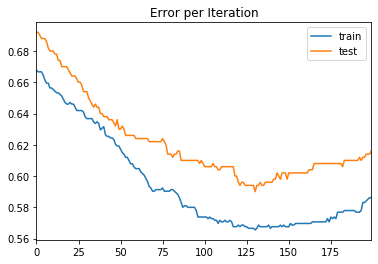

In [223]:
error = pd.DataFrame(error)
error.plot(title='Error per Iteration')

The training error and the testing error per iteration for the class 'CYT' were shown in the plot above.

### P3. Re-train the ANN with all the data

The ANN model was retrained with all the data. The training error was shown as below.

In [11]:
X_all = yeast.loc[:,1:8].values
y_all = yeast.loc[:,9].values

ec2 = LabelEncoder()
y_all = ec2.fit_transform(y_all)
dummy_y_all = to_categorical(y_all)

sc2 = StandardScaler()
sc2.fit(X_all)
X_all = sc2.transform(X_all)

In [12]:
model = Sequential()
model.add(Dense(3, input_dim = 8, activation = 'sigmoid'))
model.add(Dense(3, activation = 'sigmoid'))
model.add(Dense(10, activation = 'sigmoid'))
sgd = optimizers.SGD(lr = 0.033)
model.compile(loss = 'mean_squared_error', optimizer = 'sgd', metrics = ['accuracy'])

In [85]:
model.fit(X_all, dummy_y_all, epochs = 500, verbose = 0)

In [15]:
weight = model.layers[2].get_weights()

In [16]:
w1, w2, w3, = list(weight[0][:,0])
bias = weight[1][0]
w = {'w0':bias,'w1':w1,'w2':w2,'w3':w3}

In [17]:
w = pd.Series(w)

In [22]:
pred = model.predict(X_all).argmax(axis=1)
true = dummy_y_all.argmax(axis=1)

calc_error(true, pred)        

0.6880053908355794

The training error for the 'CYT' class is 0.6880053908355794.

In [23]:
w

w0   -0.490667
w1    0.011950
w2   -0.082615
w3   -0.347769
dtype: float64

$z_1^{(4)} = w_{10}^{(3)}*a_0^{(3)} + w_{11}^{(3)}*a_1^{(3)} + w_{12}^{(3)}*a_2^{(3)} + w_{13}^{(3)}*a_3^{(3)}$

$a_1^{(4)} = \frac{1}{1+exp(-z_1^{(4)})}$


Sigmoid function was used in the model. The final activation function formula for class 'CYT' was shown above.

### P4. Calculate the weight

In [86]:
X_all = yeast.loc[:,1:8].values
y_all = yeast.loc[:,9].values

ec2 = LabelEncoder()
y_all = ec2.fit_transform(y_all)
dummy_y_all = to_categorical(y_all)

In [677]:
def my_init(shape, dtype = None):
    init = np.zeros(shape)
    init[:,0] = 1
    return init

def my_init2(shape, dtype = None):
    init = np.zeros(shape)
    init[0] = 1
    return init

A 4 layers(2 hidden layers, 3 nodes per hidden layer) ANN was built. The first sample was used to train the model. The initial weights and bias were shown as below. 

In [692]:
model = Sequential()
model.add(Dense(3, input_dim = 8, activation = 'sigmoid', kernel_initializer = 'zeros'))
model.add(Dense(3, activation = 'sigmoid', kernel_initializer = my_init, bias_initializer=my_init2))
model.add(Dense(10, activation = 'sigmoid', kernel_initializer = my_init, bias_initializer=my_init2))
#sgd = optimizers.SGD(lr = 0.033)
model.compile(loss = 'mean_squared_error', optimizer = 'sgd', metrics = ['accuracy'])
#model.fit(X_all[0], dummy_y_all[0], epochs = 1)

model.get_weights()

[array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], dtype=float32),
 array([0., 0., 0.], dtype=float32),
 array([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]], dtype=float32),
 array([1., 0., 0.], dtype=float32),
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32),
 array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)]

In [718]:
model.fit(X_all[0:1], dummy_y_all[0:1], epochs = 1, verbose=0)

After the first round of weight updates with back-propagation, the new weights and bias produced by the code were shown as below.

In [694]:
model.get_weights()

[array([[-9.3333136e-07, -9.3333136e-07, -9.3333136e-07],
        [-9.8160717e-07, -9.8160717e-07, -9.8160717e-07],
        [-7.5632028e-07, -7.5632028e-07, -7.5632028e-07],
        [-2.0919497e-07, -2.0919497e-07, -2.0919497e-07],
        [-8.0459603e-07, -8.0459603e-07, -8.0459603e-07],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [-7.7241214e-07, -7.7241214e-07, -7.7241214e-07],
        [-3.5402226e-07, -3.5402226e-07, -3.5402226e-07]], dtype=float32),
 array([-1.609192e-06, -1.609192e-06, -1.609192e-06], dtype=float32),
 array([[ 9.9999678e-01, -1.1477225e-05, -1.1477225e-05],
        [ 9.9999678e-01, -1.1477225e-05, -1.1477225e-05],
        [ 9.9999678e-01, -1.1477225e-05, -1.1477225e-05]], dtype=float32),
 array([ 9.9999356e-01, -2.2954449e-05, -2.2954449e-05], dtype=float32),
 array([[ 9.9991512e-01, -2.3103546e-04, -2.3103546e-04, -2.3103546e-04,
         -2.3103546e-04, -2.3103546e-04,  2.3103546e-04, -2.3103546e-04,
         -2.3103546e-04, -2.3103546e-04

The calculation of weights and bias were shown as below.

**For the 1st hidden layer:**

$z_i^{(2)} = 0$, for i = 1, 2,3

$a_i^{(2)} = \frac{1}{1+exp(-z_i^{(2)})} = 1/2$, for i = 1,2,3

**For the 2nd hidden layer:**

$\begin{align*}
z_1^{(3)} &= 1a_0^{(2)} + 1a_1^{(2)} + 1a_2^{(2)} + 1a_3^{(2)}\\
       &= 1+3*1/2 = 2.5\\
a_1^{(3)} &= \frac{1}{1+exp(-z_1^{(3)})} \\       
       &= \frac{1}{1+exp(-2.5)} \\        
       &= 0.9241418199787566
\end{align*}$   

$z_i^{(3)} = 0$,for i = 2,3 \\

$a_i^{(3)} = \frac{1}{1+exp(-z_i^{(3)})} = 1/2, for i = 2,3$




**For the output layer:**

$\begin{align*}
z_1^{(4)} &= 1*a_0^{(3)} + 1*a_1^{(3)} + 1*a_2^{(3)} + 1*a_3^{(3)} \\
       &= 1+ 0.07585818002124355 + 2*1/2 \\
       &= 2.9241418199787566 \\
a_1^{(4)} &= \frac{1}{1+exp(-z_1^{(4)})} \\
       &= \frac{1}{1+exp(-2.9241418199787566)} \\
       &= 0.949027031518282
\end{align*}$ 

$z_i^{(4)} = 0$, for i = 2,3,...,10

$a_i^{(4)} = \frac{1}{1+exp(-z_i^{(4)})} = 1/2$, for i = 2,3,...,10

**The first round of weight updates:**

**(1) Output to 2nd hidden layer:**

$\delta_k^{(l)} = 2/10 * (y_k - a_k^{(l)}) * a_k^{(l)} * (1-a_k^{(l)})$

$w_{kj}^{(l-1)} = w_{kj}^{(l-1)} + \alpha * \delta_k^{(l)} * a_j^{(l-1)}$

here $\alpha = 0.01$

$\begin{align*}
\delta_1^{(4)} &= 2/10 * (y_1 - a_1^{(4)}) * a_1^{(4)} * (1-a_1^{(4)}) \\
          &= 1/5 * (0-0.949027031518282)*0.949027031518282 * (1-0.949027031518282) \\
          &= -0.009181784326976436
\end{align*}$ 

$\begin{align*}
w_{11}^{(3)} &= w_{11}^{(3)} + 0.01 * (-0.009181784326976436) * 0.9241418199787566 \\
         &= 1+(-8.485270878584425e-05) \\
         &= 0.9999151472912141 \\
w_{1k}^{(3)} &= w_{1k}^{(3)} + 0.01 * (-0.009181784326976436) * 1/2 \\
         &= 1+(-4.5908921634882176e-05) \\
         &= 0.9999540910783651
\end{align*}$ 

for k = 2,3

$\begin{align*}
w_{10}^{(3)} &= w_{10}^{(3)} + \alpha * \delta_1^{(4)} \\
         &= 1 + 0.01 * (-0.009181784326976436) \\
         &= 0.9999081821567303
\end{align*}$          

**(2) 2nd layer to 1st hidden layer:**

$\begin{align*}
\delta_1^{(3)} &= \delta_k^{(4)} * w_{kj}^{(l-1)} * a_j^{(3)} * (1-a_j^{(3)}) \\
          &= -0.009181784326976436 * 0.9999151472912141 * \\
          &\qquad 0.9241418199787566 * (1-0.9241418199787566) \\
          &= -0.0006436225880821729
\end{align*}$           

$\begin{align*}
w_{1i}^{(2)} &= w_{1i}^{(2)} + \delta_1^{(3)} * a_i^{(2)} \\
         &= 1 - 0.0006436225880821729 * 1/2 \\
         &= 0.9996781887059589
\end{align*}$           
, for i = 1,2,3

$\begin{align*}
w_{10}^{(2)} &= w_{10}^{(2)} + \alpha * \delta_1^{(3)} \\
         &= 1 + 0.01 * (-0.0006436225880821729) \\
         &= 0.9999935637741192
\end{align*}$ 

It can be seen that the code output are the same with my calculation.  

### P5. Parameter sweep

In [26]:
para = []
for node in [3,6,9,12]:
    for layer in [1,2,3]:
        model = Sequential()
        model.add(Dense(node, input_dim = 8, activation = 'sigmoid'))
        for i in range(layer-1):
            model.add(Dense(node, activation = 'sigmoid'))
        model.add(Dense(10, activation = 'sigmoid'))
        sgd = optimizers.SGD(lr = 0.035)
        model.compile(loss = 'mean_squared_error', optimizer = 'sgd')
        model.fit(X_train, y_train, epochs = 400, verbose = 0)

        true_test = y_test.argmax(axis=1)
        pred_test = model.predict(X_test).argmax(axis=1)
        
        para.append(1-accuracy_score(true_test, pred_test))
        

In [32]:
test_error = pd.DataFrame(np.array(para).reshape(4,3).T, columns=[3,6,9,12], 
                          index=[1,2,3])
test_error.index.name = 'Hidden Layers'
test_error.columns.name = 'Nodes in Each Layer'
test_error

Nodes in Each Layer,3,6,9,12
Hidden Layers,,,,
1,0.696,0.672,0.662,0.642
2,0.676,0.696,0.710,0.702
3,0.702,0.702,0.702,0.702


The testing errors of different models were shown in the table above. The optimal configuration is one hidden layer and 12 nodes in the hidden layer. It can be seen that the testing error will increase as the number of hidden layers increase, when holding the number of nodes in each hidden layer as constant. The testing error will decrease or remain the same as the number of nodes in each hidden layers increase, when hoding the number of hidden layer be constant as constant. The generalization of testing error is around 0.7.

### P6. Classification a specific sample

In [18]:
x0 = np.array([[0.52,0.47, 0.52,0.23,0.55, 0.03, 0.52, 0.39]])
x0 = sc.transform(x0)

In [22]:
model = Sequential()
model.add(Dense(12, input_dim = 8, activation = 'sigmoid'))
model.add(Dense(10, activation = 'sigmoid'))
sgd = optimizers.SGD(lr = 0.035)
model.compile(loss = 'mean_squared_error', optimizer = 'sgd')
model.fit(X_train, y_train, epochs = 400, verbose = 0)

In [23]:
model.predict(x0)

array([[0.31260622, 0.09307843, 0.08654186, 0.09317377, 0.11318883,
        0.16133937, 0.15956935, 0.35496342, 0.09122631, 0.09219179]],
      dtype=float32)

In [24]:
model.predict(x0).argmax(axis = 1)

array([7], dtype=int64)

The model was constructed using the best configuration in the problem 5 (1 hidden layer with 12 nodes). The prediction of class is 'NUC'.

### P7. Change the activation function and the loss function

The hidden layer activetion function was set to ReLU, the output layer activation was set to softmax, and the loss function was set to cross-entropy.

In [102]:
para = {'train':[], 'test':[]}
his = {'train':[], 'test':[]}
for node in [3,6,9,12]:
    for layer in [1,2,3]:
        #error = {'train':[], 'test':[]}
        model = Sequential()
        model.add(Dense(node, input_dim = 8, activation = 'relu'))
        for i in range(layer-1):
            model.add(Dense(node, activation = 'relu'))
        model.add(Dense(10, activation = 'sigmoid'))
        sgd = optimizers.SGD(lr = 0.033)
        model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ['acc'])
        history = model.fit(X_train, y_train, epochs = 400, validation_data = (X_test,y_test), verbose = 0)
        
        para['train'].append(1-model.evaluate(X_train, y_train, verbose = 0)[1])
        para['test'].append(1-model.evaluate(X_test, y_test, verbose = 0)[1])
        
        his['train'].append(list(map(lambda x: 1-x, history.history['acc'])))
        his['test'].append(list(map(lambda x: 1-x, history.history['val_acc'])))
        

The training errors of different models were shown in the table below.

In [113]:
train_error = pd.DataFrame(np.array(para['train']).reshape(4,3).T, columns=[3,6,9,12], 
                          index=[1,2,3])
train_error.index.name = 'Hidden Layers'
train_error.columns.name = 'Nodes in Each Layer'
train_error

Nodes in Each Layer,3,6,9,12
Hidden Layers,,,,
1,0.498452,0.410733,0.392157,0.392157
2,0.473684,0.459236,0.400413,0.378741
3,0.553148,0.441692,0.393189,0.381837


The testing errors of different models were shown in the table below.

In [114]:
test_error = pd.DataFrame(np.array(para['test']).reshape(4,3).T, columns=[3,6,9,12], 
                          index=[1,2,3])
test_error.index.name = 'Hidden Layers'
test_error.columns.name = 'Nodes in Each Layer'
test_error

Nodes in Each Layer,3,6,9,12
Hidden Layers,,,,
1,0.504,0.452,0.430,0.418
2,0.508,0.488,0.422,0.428
3,0.594,0.450,0.434,0.408


It is shown that the model with 2 hidden layers, 12 nodes in each hidden layer has the lowest training error, and the model with 3 hidden layers, 12 nodes in each hidden layer has the lowest testing error.

The plots of error per each iteration are shown as below. 

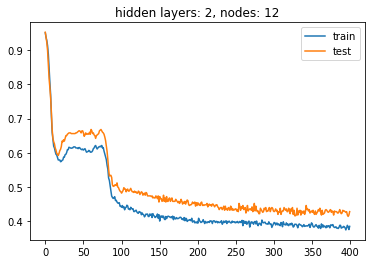

In [115]:
plt.plot(his['train'][10], label = 'train')
plt.plot(his['test'][10], label = 'test')
plt.title(('hidden layers: 2, nodes: 12'))
plt.legend(loc = 'best')
plt.show()

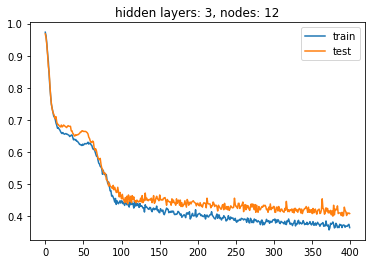

In [116]:
plt.plot(his['train'][11], label = 'train')
plt.plot(his['test'][11], label = 'test')
plt.title(('hidden layers: 3, nodes: 12'))
plt.legend(loc = 'best')
plt.show()

### P8. Uncertainty

To quantify the uncertainty for each classification, I can get a roughly idea by using the output of the output layer. For the unknown sample in P6, the output of the 1st node is 0.31260622, the output the of 8th node is 0.35496342. We can say that it is actually hard to tell whether the class of this sample is 'CYT' or 'NUC', and the uncertainty for the prediction is about 0.65.